<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/v2_MIAAD_Actividad_con_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Para Ejecutar Este codigo puede entrar al Link en Colab Directamente

https://colab.research.google.com/drive/1gCvDJFjDd7IIRrhbmVvFBXwXoEd3imKj?usp=sharing

# GitHub Link of this notebook:

### https://github.com/jrebull/AnaliticaPrescriptiva/blob/main/v2_MIAAD_Actividad_con_blocks.ipynb

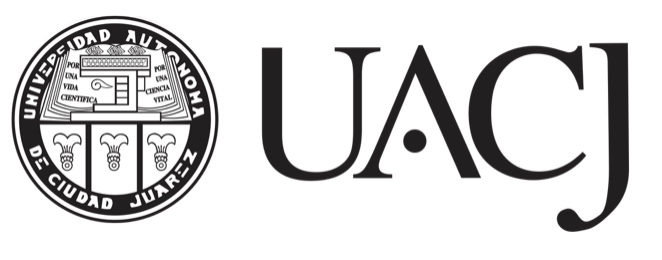

# **UNIVERSIDAD AUTÓNOMA DE CIUDAD JUÁREZ**

## **Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)**

---

# **Actividad con blocks**
### **Semana 05**

---

**Profesor titular:** Dr. Gilberto Rivera Zárate  
**Alumno:** Javier Augusto Rebull Saucedo  
**Matrícula:** 263483  

**Asignatura:** Programación para Analítica Prescriptiva y de Apoyo a la Decisión  
**Fecha:** 30 de septiembre de 2025


# Optimización de Cuotas de Caza Sostenible de Ciervos: Un Enfoque Multi-periodo

## Introducción

El presente trabajo implementa y extiende el modelo de optimización no lineal para la gestión sostenible de poblaciones de ciervos, originalmente propuesto por Bailey (1984). El objetivo principal es determinar las cuotas óptimas de caza que maximicen el valor de la cosecha mientras se mantiene la viabilidad ecológica de la población a largo plazo.

### Contexto del Problema

La gestión de poblaciones de fauna silvestre requiere un equilibrio delicado entre:
- **Aprovechamiento económico**: Maximizar el valor de las licencias de caza
- **Sostenibilidad ecológica**: Mantener poblaciones viables
- **Restricciones del hábitat**: Respetar la capacidad de carga del ecosistema

### Objetivos del Trabajo

1. **Replicar** el modelo original de estado estacionario de Bailey (1984)
2. **Extender** el modelo a múltiples periodos usando programación estructurada con blocks de Pyomo
3. **Comparar** ambos enfoques y analizar sus implicaciones para la gestión práctica
4. **Implementar** restricciones de sostenibilidad para evitar sobreexplotación

### Metodología

El trabajo se divide en dos implementaciones principales:

#### A. Modelo de Estado Estacionario
- Replica exactamente el paper original
- Un solo periodo en equilibrio perpetuo
- Variables continuas
- Sistema de ecuaciones no lineales (7.7-7.13)

#### B. Modelo Multi-periodo Dinámico
- Extensión temporal usando blocks de Pyomo
- Variables enteras (más realista)
- Conexión temporal entre periodos
- Restricciones explícitas de sostenibilidad

### Estructura del Documento

El desarrollo incluye la implementación completa en Python/Pyomo, análisis de resultados, visualizaciones y conclusiones sobre la aplicabilidad de cada enfoque en la gestión real de recursos naturales.

# Instalacion de Dependencias

In [1]:
# Quitar el repo problemático si existe
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list 2>/dev/null || true
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list.d/* 2>/dev/null || true

# Instalar micromamba (binario)
!wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null

# Crear un entorno con ipopt y pyomo desde conda-forge
!./bin/micromamba create -y -p /usr/local/ipopt-env -c conda-forge ipopt pyomo > /dev/null

# Exponer el ejecutable ipopt
!ln -sf /usr/local/ipopt-env/bin/ipopt /usr/bin/ipopt

# Comprobar instalación
!which ipopt
!ipopt -v

/usr/bin/ipopt
Ipopt 3.14.19 (Linux x86_64), ASL(20231111)




# CELDA 2: Importaciones y configuración

In [2]:
import pyomo.environ as pyo # Importa Pyomo, una librería para modelar y resolver problemas de optimización matemática.
import numpy as np # Importa NumPy, fundamental para el cálculo numérico y el trabajo con arrays en Python.
import pandas as pd # Importa Pandas, utilizada para la manipulación y el análisis de datos, especialmente con estructuras como DataFrames.
import matplotlib.pyplot as plt # Importa Matplotlib, una librería para la creación de gráficos y visualizaciones de datos.
import warnings # Importa el módulo de advertencias para controlar cómo se manejan.
warnings.filterwarnings('ignore') # Configura que se ignoren las advertencias para mantener la salida más limpia.

print("📚 Librerías importadas correctamente")

📚 Librerías importadas correctamente


# CELDA 3: INTRODUCCIÓN Y CONFIGURACIÓN


> ```
> ╔════════════════════════════════════════════════════════════════════════════╗
> ║  MODELO DE OPTIMIZACIÓN DE CAZA SOSTENIBLE DE CIERVOS                     ║
> ║  Basado en: Bailey (1984) - Optimal Quotas for Sustainable Harvesting     ║
> ╚════════════════════════════════════════════════════════════════════════════╝
> ```
>
> Este notebook implementa **DOS** versiones del modelo:
>
> ---
>
> ### 1. MODELO ESTADO ESTACIONARIO (Sección A)
> - Replica **EXACTAMENTE** el paper original.
> - Un solo periodo en equilibrio (steady-state).
> - Variables continuas.
> - `Resultado esperado:` ~62 bucks, ~37 does, ~0 fawns.
>
> ### 2. MODELO MULTI-PERIODO DINÁMICO (Sección B)
> - Extensión con `blocks` de Pyomo.
> - Múltiples periodos configurables.
> - Variables enteras (más realista).
> - Conexión temporal entre periodos.
>    
> ---
>    
> ### **NOMENCLATURA:**
> * **Cervatillos (Fawns)** - Crías menores de 1 año.
> * **Hembras (Does)** - Hembras adultas reproductivas.
> * **Machos (Bucks)** - Machos adultos.

In [3]:
print("📚 MODELO DE CAZA SOSTENIBLE DE CIERVOS")
print("="*60)
print("Notebook con dos implementaciones:")
print("  A) Estado Estacionario (paper original)")
print("  B) Multi-periodo Dinámico (extensión con blocks)")
print("="*60)

📚 MODELO DE CAZA SOSTENIBLE DE CIERVOS
Notebook con dos implementaciones:
  A) Estado Estacionario (paper original)
  B) Multi-periodo Dinámico (extensión con blocks)


# CELDA 4: PARÁMETROS GLOBALES

# Parámetros del Modelo de Optimización para Caza Sostenible de Ciervos

Este modelo está basado en el trabajo de Bailey [5] y representa un sistema dinámico complejo que modela la población de ciervos considerando tasas de fertilidad, supervivencia y consumo energético. A continuación se presenta la **deconstrucción integral** de cada parámetro.

## 🔄 Parámetros de Producción y Fertilidad

### `p1 = 0.88` - Coeficiente de Producción de Cervatos
- **Definición Formal**: Factor de escala para los nacimientos totales en la población
- **Interpretación Ecológica**: Probabilidad combinada de que las hembras preñadas sobrevivan hasta el parto Y que sus crías sobrevivan el período neonatal (verano)
- **Derivación Biológica**: `p1 = S_madre,pre-parto × S_cervato,neonatal`
- **Importancia**: Integra dos procesos críticos: supervivencia maternal y supervivencia temprana de las crías

### `p2 = 0.82` - Tasa de Fertilidad de Hembras Jóvenes  
- **Definición Formal**: Tasa de fertilidad de las hembras jóvenes (cervatos del año anterior)
- **Interpretación Ecológica**: Tasa de natalidad promedio para las hembras que se reproducen en su **primer año de vida**
- **Derivación Biológica**: Medida directa de campo (tasa de preñez de hembras de un año)
- **Significado**: Las hembras jóvenes tienen menor capacidad reproductiva que las adultas

### `p3 = 0.92` - Tasa de Fertilidad de Hembras Adultas
- **Definición Formal**: Tasa de fertilidad de las hembras adultas (dos años o más)
- **Interpretación Ecológica**: Tasa de natalidad promedio para hembras de **dos años o más**
- **Derivación Biológica**: Medida directa de campo (tasa de preñez de hembras adultas)
- **Comparación**: Significativamente mayor que `p2`, reflejando la madurez reproductiva

## 🦌 Parámetros de Supervivencia Anual

### `p4 = 0.84` - Supervivencia Anual de Hembras Adultas
- **Definición Formal**: Tasa de supervivencia anual de las hembras adultas
- **Interpretación Ecológica**: Probabilidad de que una hembra adulta sobreviva un año completo por **causas naturales** (excluyendo la cosecha)
- **Derivación Biológica**: `p4 = S_invierno,h × S_reproducción,h × S_verano,h × S_cosecha,h` (h=hembra)
- **Nota Crítica**: NO incluye mortalidad por caza, solo factores naturales

### `p5 = 0.73` - Supervivencia de Cervatos hasta Primer Año
- **Definición Formal**: Tasa de supervivencia anual de los cervatos hasta convertirse en individuos de un año
- **Interpretación Ecológica**: Probabilidad de que un cervato sobreviva desde el otoño de un año hasta el otoño del siguiente
- **Derivación Biológica**: `p5 = S_invierno,c × S_reproducción,c × S_verano,c × S_cosecha,c` (c=cervato)
- **Importancia**: Período más vulnerable de la vida del ciervo

### `p6 = 0.87` - Supervivencia Anual de Machos Adultos  
- **Definición Formal**: Tasa de supervivencia anual de los machos adultos
- **Interpretación Ecológica**: Probabilidad de que un macho adulto sobreviva un año completo por **causas naturales** (excluyendo la cosecha)
- **Derivación Biológica**: `p6 = S_invierno,m × S_reproducción,m × S_verano,m × S_cosecha,m` (m=macho)
- **Observación**: Mayor supervivencia que hembras, posiblemente por menor estrés reproductivo

## 🌿 Parámetros Energéticos y de Capacidad de Carga

### `p7 = 2,700` - Consumo Anual per cápita de Machos
- **Definición Formal**: Consumo anual de alimento per cápita de un macho adulto
- **Unidades**: Libras por año por individuo
- **Interpretación Ecológica**: Requerimiento energético anual de un macho adulto
- **Derivación**: Estimado mediante estudios metabólicos y análisis de dieta

### `p8 = 2,300` - Consumo Anual per cápita de Hembras
- **Definición Formal**: Consumo anual de alimento per cápita de una hembra adulta  
- **Unidades**: Libras por año por individuo
- **Interpretación Ecológica**: Requerimiento energético anual de una hembra adulta
- **Comparación**: ~15% menor que machos, reflejando dimorfismo sexual

### `p9 = 540` - Consumo Anual per cápita de Cervatos
- **Definición Formal**: Consumo anual de alimento per cápita de un cervato
- **Unidades**: Libras por año por individuo  
- **Interpretación Ecológica**: Requerimiento energético anual de un cervato
- **Proporción**: ~23% del consumo de un macho adulto

### `ps = 700,000` - Capacidad de Carga del Hábitat
- **Definición Formal**: Suministro total de alimento disponible en el ecosistema
- **Unidades**: Libras totales por año
- **Interpretación Ecológica**: Capacidad de carga del hábitat, expresada en biomasa de forraje
- **Derivación**: Medida directa del hábitat (productividad de forraje)
- **Función**: **Restricción fundamental** que limita el tamaño poblacional máximo

## 💰 Parámetros Económicos (Valores de Cosecha)

### `wf = 1.0` - Valor Relativo de Cervato
- **Significado**: Valor económico base para la cosecha de cervatos

### `wd = 1.0` - Valor Relativo de Hembra  
- **Significado**: Valor económico equivalente al de cervatos

### `wb = 10.0` - Valor Relativo de Macho
- **Significado**: Valor económico **10 veces superior** al de hembras/cervatos
- **Justificación**: Refleja la preferencia del mercado por trofeos de machos con cornamentas

## 🎯 Integración del Modelo

El modelo combina estos parámetros en un sistema de ecuaciones diferenciales que captura:

1. **Dinámica Reproductiva**: `p1`, `p2`, `p3` determinan la producción de nuevos individuos
2. **Mortalidad Natural**: `p4`, `p5`, `p6` modelan la supervivencia sin intervención humana
3. **Limitaciones Ambientales**: `p7`, `p8`, `p9`, `ps` imponen restricciones de capacidad de carga
4. **Objetivos Económicos**: `wf`, `wd`, `wb` definen la función objetivo a maximizar

---
*Basado en: Deconstrucción Integral de Parámetros - Modelo de Bailey [5]*

In [4]:
# Parámetros del modelo (Tabla 7.3 del paper)
PARAMETROS_PAPER = {
    'p1': 0.88,   # Coeficiente de producción de cervatos; factor de escala para los nacimientos totales.
    'p2': 0.82,   # Tasa de fertilidad de las hembras jóvenes (cervatos del año anterior).
    'p3': 0.92,   # Tasa de fertilidad de las hembras adultas.
    'p4': 0.84,   # Tasa de supervivencia anual de las hembras adultas.
    'p5': 0.73,   # Tasa de supervivencia anual de los cervatos hasta convertirse en individuos de un año.
    'p6': 0.87,   # Tasa de supervivencia anual de los machos adultos.
    'p7': 2700,   # Consumo anual de alimento per cápita de un macho (lbs).
    'p8': 2300,   # Consumo anual de alimento per cápita de una hembra (lbs).
    'p9': 540,    # Consumo anual de alimento per cápita de un cervato (lbs).
    'ps': 700000, # Suministro total de alimento disponible (lbs).
    'wf': 1.0,    # Valor cosecha cervatillo
    'wd': 1.0,    # Valor cosecha hembra
    'wb': 10.0    # Valor cosecha macho (10× más valioso)
}

print("📊 PARÁMETROS DEL MODELO (Bailey, 1984):")
print("-"*60)
for key, value in PARAMETROS_PAPER.items():
    if key.startswith('p') and key != 'ps':
        print(f"  {key}: {value:7.2f}")
print(f"  ps: {PARAMETROS_PAPER['ps']:,} libras (suministro alimento)")
print(f"\n  Pesos función objetivo:")
print(f"    Bucks: {PARAMETROS_PAPER['wb']} | Does: {PARAMETROS_PAPER['wd']} | Fawns: {PARAMETROS_PAPER['wf']}")

📊 PARÁMETROS DEL MODELO (Bailey, 1984):
------------------------------------------------------------
  p1:    0.88
  p2:    0.82
  p3:    0.92
  p4:    0.84
  p5:    0.73
  p6:    0.87
  p7: 2700.00
  p8: 2300.00
  p9:  540.00
  ps: 700,000 libras (suministro alimento)

  Pesos función objetivo:
    Bucks: 10.0 | Does: 1.0 | Fawns: 1.0


# SECCIÓN A: MODELO ESTADO ESTACIONARIO
# CELDA 5: DEFINICIÓN MODELO ESTADO ESTACIONARIO

In [5]:
print("\n" + "="*70)
print(" SECCIÓN A: MODELO ESTADO ESTACIONARIO (PAPER ORIGINAL)")
print("="*70)

def crear_modelo_estado_estacionario(params=PARAMETROS_PAPER):
    """
    Modelo de estado estacionario (steady-state) - Replica exacta del paper.

    CARACTERÍSTICAS:
    - Un solo periodo en equilibrio
    - Variables continuas
    - Poblaciones constantes año tras año
    - Sistema de ecuaciones no lineales (7.7-7.13)
    """

    print("\n📝 Creando modelo de ESTADO ESTACIONARIO...")
    print("   • Un solo periodo (equilibrio)")
    print("   • Variables continuas")
    print("   • Replica exacta del paper")

    model = pyo.ConcreteModel(name="Deer_SteadyState")

    # Parámetros
    for key, value in params.items():
        setattr(model, key, value)

    # ========================================
    # VARIABLES DE DECISIÓN (continuas)
    # ========================================

    # Poblaciones en estado estacionario
    model.f = pyo.Var(bounds=(0, 1000), within=pyo.NonNegativeReals,
                      initialize=100, doc="Cervatillos (Fawns)")
    model.d = pyo.Var(bounds=(0, 1000), within=pyo.NonNegativeReals,
                      initialize=100, doc="Hembras (Does)")
    model.b = pyo.Var(bounds=(0, 1000), within=pyo.NonNegativeReals,
                      initialize=80, doc="Machos (Bucks)")

    # Variables de cosecha
    model.hf = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeReals,
                       initialize=0, doc="Cosecha Fawns")
    model.hd = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeReals,
                       initialize=30, doc="Cosecha Does")
    model.hb = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeReals,
                       initialize=50, doc="Cosecha Bucks")

    # Variables auxiliares
    model.br = pyo.Var(bounds=(1.0, 2.0), within=pyo.NonNegativeReals,
                       initialize=1.5, doc="Tasa natalidad")
    model.c = pyo.Var(bounds=(0, 1000000), within=pyo.NonNegativeReals,
                      initialize=500000, doc="Consumo alimento")

    # ========================================
    # RESTRICCIONES (Ecuaciones 7.7-7.13)
    # ========================================

    # Ecuación 7.7: Balance cervatillos (estado estacionario)
    def balance_fawns_rule(m):
        nacimientos = m.p1 * m.br * (m.p2/10.0 * m.f + m.p3 * m.d)
        return m.f == nacimientos - m.hf
    model.balance_fawns = pyo.Constraint(rule=balance_fawns_rule,
                                         doc="Ec. 7.7: f = p1*br*(p2/10*f + p3*d) - hf")

    # Ecuación 7.8: Balance hembras (estado estacionario)
    def balance_does_rule(m):
        supervivientes = m.p4 * m.d
        maduracion = m.p5 / 2.0 * m.f
        return m.d == supervivientes + maduracion - m.hd
    model.balance_does = pyo.Constraint(rule=balance_does_rule,
                                        doc="Ec. 7.8: d = p4*d + p5/2*f - hd")

    # Ecuación 7.9: Balance machos (estado estacionario)
    def balance_bucks_rule(m):
        supervivientes = m.p6 * m.b
        maduracion = m.p5 / 2.0 * m.f
        return m.b == supervivientes + maduracion - m.hb
    model.balance_bucks = pyo.Constraint(rule=balance_bucks_rule,
                                         doc="Ec. 7.9: b = p6*b + p5/2*f - hb")

    # Ecuación 7.10: Tasa de natalidad
    def birth_rate_rule(m):
        return m.br == 1.1 + 0.8 * (m.ps - m.c) / m.ps
    model.birth_rate = pyo.Constraint(rule=birth_rate_rule,
                                      doc="Ec. 7.10: br = 1.1 + 0.8*(ps-c)/ps")

    # Ecuación 7.11: Consumo de alimento
    def food_consumption_rule(m):
        return m.c == m.p7 * m.b + m.p8 * m.d + m.p9 * m.f
    model.food_consumption = pyo.Constraint(rule=food_consumption_rule,
                                           doc="Ec. 7.11: c = p7*b + p8*d + p9*f")

    # Ecuación 7.12: Restricción suministro
    def supply_constraint_rule(m):
        return m.c <= m.ps
    model.supply_constraint = pyo.Constraint(rule=supply_constraint_rule,
                                            doc="Ec. 7.12: c <= ps")

    # Ecuación 7.13: Proporción mínima machos (minbuck)
    def minbuck_rule(m):
        return m.b >= (1.0/5.0) * (0.4 * m.f + m.d)
    model.minbuck = pyo.Constraint(rule=minbuck_rule,
                                  doc="Ec. 7.13: b >= 1/5*(0.4*f + d)")

    # ========================================
    # FUNCIÓN OBJETIVO (Ecuación 7.6)
    # ========================================

    def objective_rule(m):
        return m.wb * m.hb + m.wd * m.hd + m.wf * m.hf
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize,
                                   doc="Ec. 7.6: max wb*hb + wd*hd + wf*hf")

    print("✅ Modelo estado estacionario creado")
    return model



 SECCIÓN A: MODELO ESTADO ESTACIONARIO (PAPER ORIGINAL)


# CELDA 6: RESOLVER MODELO ESTADO ESTACIONARIO

In [6]:
print("\n🔧 RESOLVIENDO MODELO ESTADO ESTACIONARIO...")
print("-"*60)

# Crear modelo
model_ss = crear_modelo_estado_estacionario()

# Resolver con IPOPT
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 3000
solver.options['tol'] = 1e-6
solver.options['print_level'] = 0

results_ss = solver.solve(model_ss, tee=False)



🔧 RESOLVIENDO MODELO ESTADO ESTACIONARIO...
------------------------------------------------------------

📝 Creando modelo de ESTADO ESTACIONARIO...
   • Un solo periodo (equilibrio)
   • Variables continuas
   • Replica exacta del paper
✅ Modelo estado estacionario creado


# CELDA 7: RESULTADOS ESTADO ESTACIONARIO


In [7]:
from pyomo.opt import SolverStatus, TerminationCondition

if (results_ss.solver.status == SolverStatus.ok and
    results_ss.solver.termination_condition == TerminationCondition.optimal):

    print("\n" + "="*70)
    print(" 🏆 SOLUCIÓN ÓPTIMA - ESTADO ESTACIONARIO (PAPER ORIGINAL)")
    print("="*70)

    # Extraer valores
    f_val = pyo.value(model_ss.f)
    d_val = pyo.value(model_ss.d)
    b_val = pyo.value(model_ss.b)
    hf_val = pyo.value(model_ss.hf)
    hd_val = pyo.value(model_ss.hd)
    hb_val = pyo.value(model_ss.hb)
    br_val = pyo.value(model_ss.br)
    c_val = pyo.value(model_ss.c)
    obj_val = pyo.value(model_ss.objective)

    print("\n📊 POBLACIONES EN EQUILIBRIO:")
    print("-"*50)
    print(f"  Cervatillos (Fawns):  {f_val:8.2f}")
    print(f"  Hembras (Does):       {d_val:8.2f}")
    print(f"  Machos (Bucks):       {b_val:8.2f}")
    print(f"  {'─'*30}")
    print(f"  POBLACIÓN TOTAL:      {f_val + d_val + b_val:8.2f}")

    print("\n🎯 COSECHA ÓPTIMA ANUAL:")
    print("-"*50)
    print(f"  Cervatillos (Fawns):  {hf_val:8.2f}  ({hf_val:.0f})")
    print(f"  Hembras (Does):       {hd_val:8.2f}  ({hd_val:.0f})")
    print(f"  Machos (Bucks):       {hb_val:8.2f}  ({hb_val:.0f})")
    print(f"  {'─'*30}")
    print(f"  COSECHA TOTAL:        {hf_val + hd_val + hb_val:8.2f}")

    print("\n📈 MÉTRICAS DEL SISTEMA:")
    print("-"*50)
    print(f"  Tasa de natalidad:    {br_val:8.4f}")
    print(f"  Consumo alimento:     {c_val:,.0f} libras")
    print(f"  % Alimento usado:     {(c_val/model_ss.ps)*100:8.2f}%")
    print(f"  Alimento disponible:  {model_ss.ps - c_val:,.0f} libras")

    print("\n💰 FUNCIÓN OBJETIVO:")
    print("-"*50)
    print(f"  Valor óptimo:         {obj_val:8.2f}")
    print(f"  Cálculo: 10×{hb_val:.1f} + 1×{hd_val:.1f} + 1×{hf_val:.1f}")

    print("\n✅ COMPARACIÓN CON PAPER ORIGINAL:")
    print("-"*50)
    print("  Paper:   62 bucks, 37 does, 0 fawns")
    print(f"  Modelo:  {hb_val:.0f} bucks, {hd_val:.0f} does, {hf_val:.0f} fawns")

    # Verificar restricción minbuck
    minbuck_slack = pyo.value(model_ss.b - (1/5)*(0.4*model_ss.f + model_ss.d))
    print(f"\n📍 Restricción minbuck slack: {minbuck_slack:.4f}")
    if abs(minbuck_slack) < 0.01:
        print("   → Restricción ACTIVA (binding)")


 🏆 SOLUCIÓN ÓPTIMA - ESTADO ESTACIONARIO (PAPER ORIGINAL)

📊 POBLACIONES EN EQUILIBRIO:
--------------------------------------------------
  Cervatillos (Fawns):    189.61
  Hembras (Does):         196.01
  Machos (Bucks):          54.37
  ──────────────────────────────
  POBLACIÓN TOTAL:        439.98

🎯 COSECHA ÓPTIMA ANUAL:
--------------------------------------------------
  Cervatillos (Fawns):      0.00  (0)
  Hembras (Does):          37.85  (38)
  Machos (Bucks):          62.14  (62)
  ──────────────────────────────
  COSECHA TOTAL:           99.98

📈 MÉTRICAS DEL SISTEMA:
--------------------------------------------------
  Tasa de natalidad:      1.1000
  Consumo alimento:     700,000 libras
  % Alimento usado:       100.00%
  Alimento disponible:  0 libras

💰 FUNCIÓN OBJETIVO:
--------------------------------------------------
  Valor óptimo:           659.22
  Cálculo: 10×62.1 + 1×37.8 + 1×0.0

✅ COMPARACIÓN CON PAPER ORIGINAL:
----------------------------------------------

# SECCIÓN B: MODELO MULTI-PERIODO DINÁMICO

# CELDA 8: SOLICITAR NÚMERO DE PERIODOS


In [8]:
print("\n\n" + "="*70)
print(" SECCIÓN B: MODELO MULTI-PERIODO DINÁMICO (EXTENSIÓN CON BLOCKS)")
print("="*70)

print("\n📅 CONFIGURACIÓN MULTI-PERIODO")
print("-"*40)

# Solicitar número de periodos al usuario
try:
    num_periodos_input = input("¿Cuántos periodos deseas simular? (1-10, default=3): ")
    if num_periodos_input.strip() == "":
        NUM_PERIODOS = 3
    else:
        NUM_PERIODOS = int(num_periodos_input)
        if NUM_PERIODOS < 1 or NUM_PERIODOS > 10:
            print("⚠️ Valor fuera de rango. Usando 3 periodos.")
            NUM_PERIODOS = 3
except:
    NUM_PERIODOS = 3
    print("⚠️ Entrada no válida. Usando 3 periodos.")

print(f"\n✅ Configurado para {NUM_PERIODOS} periodos")



 SECCIÓN B: MODELO MULTI-PERIODO DINÁMICO (EXTENSIÓN CON BLOCKS)

📅 CONFIGURACIÓN MULTI-PERIODO
----------------------------------------
¿Cuántos periodos deseas simular? (1-10, default=3): 5

✅ Configurado para 5 periodos


# CELDA 9: DEFINICIÓN MODELO MULTI-PERIODO

In [9]:
def crear_modelo_multiperiodo(num_periodos=3, params=PARAMETROS_PAPER):
    """
    Modelo multi-periodo dinámico con blocks.

    DIFERENCIAS CON ESTADO ESTACIONARIO:
    - Múltiples periodos conectados temporalmente
    - Variables enteras (poblaciones y cosechas)
    - Población evoluciona dinámicamente
    - Restricciones de sostenibilidad al final
    - Usa blocks de Pyomo para estructura jerárquica
    """

    print(f"\n📝 Creando modelo MULTI-PERIODO DINÁMICO...")
    print(f"   • {num_periodos} periodos conectados")
    print(f"   • Variables ENTERAS")
    print(f"   • Evolución temporal dinámica")
    print(f"   • Estructura con blocks de Pyomo")

    model = pyo.ConcreteModel(name="Deer_MultiPeriod")

    # Periodos
    model.PERIODOS = pyo.RangeSet(1, num_periodos)

    # Parámetros
    for key, value in params.items():
        setattr(model, key, value)

    # Población inicial
    model.f0 = 150  # Cervatillos iniciales
    model.d0 = 120  # Hembras iniciales
    model.b0 = 80   # Machos iniciales

    # ========================================
    # DEFINICIÓN DE BLOCKS (uno por periodo)
    # ========================================

    def periodo_rule(bloque, t):
        """Define estructura de cada periodo."""

        # Variables población (ENTERAS - diferencia clave)
        bloque.f = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeIntegers,
                          initialize=100, doc=f"Fawns periodo {t}")
        bloque.d = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeIntegers,
                          initialize=100, doc=f"Does periodo {t}")
        bloque.b = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeIntegers,
                          initialize=80, doc=f"Bucks periodo {t}")

        # Variables cosecha (ENTERAS)
        bloque.hf = pyo.Var(bounds=(0, 200), within=pyo.NonNegativeIntegers,
                           initialize=5, doc=f"Harvest fawns {t}")
        bloque.hd = pyo.Var(bounds=(0, 200), within=pyo.NonNegativeIntegers,
                           initialize=5, doc=f"Harvest does {t}")
        bloque.hb = pyo.Var(bounds=(0, 200), within=pyo.NonNegativeIntegers,
                           initialize=5, doc=f"Harvest bucks {t}")

        # Variables auxiliares
        bloque.br = pyo.Var(bounds=(1.0, 2.0), within=pyo.NonNegativeReals,
                           initialize=1.5)
        bloque.c = pyo.Var(bounds=(0, 1000000), within=pyo.NonNegativeReals,
                          initialize=500000)

        # Poblaciones iniciales del periodo
        bloque.f_inicial = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeIntegers)
        bloque.d_inicial = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeIntegers)
        bloque.b_inicial = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeIntegers)

        # Nacimientos (auxiliar para redondeo)
        bloque.nacimientos = pyo.Var(bounds=(0, 500), within=pyo.NonNegativeReals)

        # ====================================
        # Restricciones del periodo
        # ====================================

        m = bloque.model()

        # Cálculo nacimientos
        def calc_nacimientos_rule(b):
            return b.nacimientos == m.p1 * b.br * (m.p2/10.0 * b.f_inicial + m.p3 * b.d_inicial)
        bloque.calc_nacimientos = pyo.Constraint(rule=calc_nacimientos_rule)

        # Balance poblaciones (con redondeo para enteros)
        def f_balance_rule(b):
            return b.f <= b.nacimientos - b.hf + 0.9999
        bloque.f_balance = pyo.Constraint(rule=f_balance_rule)

        def f_balance_lower_rule(b):
            return b.f >= b.nacimientos - b.hf
        bloque.f_balance_lower = pyo.Constraint(rule=f_balance_lower_rule)

        def d_balance_rule(b):
            return b.d <= m.p4 * b.d_inicial + m.p5/2 * b.f_inicial - b.hd + 0.9999
        bloque.d_balance = pyo.Constraint(rule=d_balance_rule)

        def d_balance_lower_rule(b):
            return b.d >= m.p4 * b.d_inicial + m.p5/2 * b.f_inicial - b.hd
        bloque.d_balance_lower = pyo.Constraint(rule=d_balance_lower_rule)

        def b_balance_rule(b):
            return b.b <= m.p6 * b.b_inicial + m.p5/2 * b.f_inicial - b.hb + 0.9999
        bloque.b_balance = pyo.Constraint(rule=b_balance_rule)

        def b_balance_lower_rule(b):
            return b.b >= m.p6 * b.b_inicial + m.p5/2 * b.f_inicial - b.hb
        bloque.b_balance_lower = pyo.Constraint(rule=b_balance_lower_rule)

        # Límites de cosecha
        def harvest_limit_hf_rule(b):
            return b.hf <= b.nacimientos
        bloque.harvest_limit_hf = pyo.Constraint(rule=harvest_limit_hf_rule)

        def harvest_limit_hd_rule(b):
            return b.hd <= m.p4 * b.d_inicial + m.p5/2 * b.f_inicial
        bloque.harvest_limit_hd = pyo.Constraint(rule=harvest_limit_hd_rule)

        def harvest_limit_hb_rule(b):
            return b.hb <= m.p6 * b.b_inicial + m.p5/2 * b.f_inicial
        bloque.harvest_limit_hb = pyo.Constraint(rule=harvest_limit_hb_rule)

        # Consumo y suministro
        def food_cons_rule(b):
            return b.c == m.p7 * b.b_inicial + m.p8 * b.d_inicial + m.p9 * b.f_inicial
        bloque.food_cons = pyo.Constraint(rule=food_cons_rule)

        def supply_rule(b):
            return b.c <= m.ps
        bloque.supply = pyo.Constraint(rule=supply_rule)

        # Tasa natalidad
        def birth_rate_rule(b):
            return b.br == 1.1 + 0.8 * (m.ps - b.c) / m.ps
        bloque.birth_rate = pyo.Constraint(rule=birth_rate_rule)

        # Proporción mínima machos
        def minbuck_rule(b):
            return b.b >= 0.2 * (0.4 * b.f + b.d)
        bloque.minbuck = pyo.Constraint(rule=minbuck_rule)

        return bloque

    # Crear blocks
    model.periodo = pyo.Block(model.PERIODOS, rule=periodo_rule)

    # ========================================
    # CONEXIÓN ENTRE PERIODOS (diferencia clave)
    # ========================================

    model.conexion = pyo.ConstraintList()
    for t in model.PERIODOS:
        if t == 1:
            # Primer periodo: población inicial
            model.conexion.add(model.periodo[t].f_inicial == model.f0)
            model.conexion.add(model.periodo[t].d_inicial == model.d0)
            model.conexion.add(model.periodo[t].b_inicial == model.b0)
        else:
            # Siguientes: población del periodo anterior
            model.conexion.add(model.periodo[t].f_inicial == model.periodo[t-1].f)
            model.conexion.add(model.periodo[t].d_inicial == model.periodo[t-1].d)
            model.conexion.add(model.periodo[t].b_inicial == model.periodo[t-1].b)

    # ========================================
    # RESTRICCIONES DE SOSTENIBILIDAD
    # ========================================

    # Población mínima final (80% de inicial)
    def sostenibilidad_rule(m):
        pob_inicial = m.f0 + m.d0 + m.b0
        pob_final = (m.periodo[num_periodos].f +
                    m.periodo[num_periodos].d +
                    m.periodo[num_periodos].b)
        return pob_final >= 0.8 * pob_inicial
    model.sostenibilidad = pyo.Constraint(rule=sostenibilidad_rule)

    # Diversidad genética
    model.diversidad = pyo.ConstraintList()
    model.diversidad.add(model.periodo[num_periodos].f >= 20)
    model.diversidad.add(model.periodo[num_periodos].d >= 30)
    model.diversidad.add(model.periodo[num_periodos].b >= 15)

    # ========================================
    # FUNCIÓN OBJETIVO (suma ponderada)
    # ========================================

    def objetivo_multiperiodo_rule(m):
        cosecha_total = 0
        descuento = 0.95  # Factor descuento temporal

        for t in m.PERIODOS:
            factor = descuento ** (t-1)
            cosecha = (m.wb * m.periodo[t].hb +
                      m.wd * m.periodo[t].hd +
                      m.wf * m.periodo[t].hf)
            cosecha_total += factor * cosecha

        return cosecha_total

    model.objetivo = pyo.Objective(rule=objetivo_multiperiodo_rule, sense=pyo.maximize)

    print("✅ Modelo multi-periodo creado")
    return model

# CELDA 10: RESOLVER MODELO MULTI-PERIODO

In [10]:
print(f"\n🔧 RESOLVIENDO MODELO MULTI-PERIODO ({NUM_PERIODOS} periodos)...")
print("-"*60)

# Crear modelo
model_mp = crear_modelo_multiperiodo(NUM_PERIODOS)

# Resolver
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 5000
solver.options['tol'] = 1e-6
solver.options['print_level'] = 0

results_mp = solver.solve(model_mp, tee=False)


🔧 RESOLVIENDO MODELO MULTI-PERIODO (5 periodos)...
------------------------------------------------------------

📝 Creando modelo MULTI-PERIODO DINÁMICO...
   • 5 periodos conectados
   • Variables ENTERAS
   • Evolución temporal dinámica
   • Estructura con blocks de Pyomo
✅ Modelo multi-periodo creado


# CELDA 11: RESULTADOS MULTI-PERIODO

In [11]:
if (results_mp.solver.status == SolverStatus.ok):

    print("\n" + "="*70)
    print(f" 🏆 SOLUCIÓN ÓPTIMA - MODELO MULTI-PERIODO ({NUM_PERIODOS} PERIODOS)")
    print("="*70)

    # Recolectar datos para tabla
    datos_periodos = []

    for t in model_mp.PERIODOS:
        periodo = model_mp.periodo[t]

        # Valores
        f_ini = int(pyo.value(periodo.f_inicial))
        d_ini = int(pyo.value(periodo.d_inicial))
        b_ini = int(pyo.value(periodo.b_inicial))
        f_fin = int(pyo.value(periodo.f))
        d_fin = int(pyo.value(periodo.d))
        b_fin = int(pyo.value(periodo.b))
        hf = int(pyo.value(periodo.hf))
        hd = int(pyo.value(periodo.hd))
        hb = int(pyo.value(periodo.hb))
        br = pyo.value(periodo.br)
        c = pyo.value(periodo.c)

        datos_periodos.append({
            'Periodo': t,
            'F_ini': f_ini, 'D_ini': d_ini, 'B_ini': b_ini,
            'F_fin': f_fin, 'D_fin': d_fin, 'B_fin': b_fin,
            'HF': hf, 'HD': hd, 'HB': hb,
            'BR': br, 'Consumo': c,
            'Pob_Total_Ini': f_ini + d_ini + b_ini,
            'Pob_Total_Fin': f_fin + d_fin + b_fin,
            'Cosecha_Total': hf + hd + hb
        })

        print(f"\n{'='*60}")
        print(f" PERIODO {t}")
        print('='*60)

        print(f"\n📊 POBLACIÓN INICIAL:")
        print(f"  Fawns: {f_ini:4d} | Does: {d_ini:4d} | Bucks: {b_ini:4d} | Total: {f_ini+d_ini+b_ini:4d}")

        print(f"\n📈 POBLACIÓN FINAL:")
        print(f"  Fawns: {f_fin:4d} | Does: {d_fin:4d} | Bucks: {b_fin:4d} | Total: {f_fin+d_fin+b_fin:4d}")

        print(f"\n🎯 COSECHA:")
        print(f"  Fawns: {hf:4d} | Does: {hd:4d} | Bucks: {hb:4d} | Total: {hf+hd+hb:4d}")

        print(f"\n📊 MÉTRICAS:")
        print(f"  Tasa natalidad: {br:.4f} | Consumo: {c:,.0f} | %Usado: {(c/model_mp.ps)*100:.1f}%")

    # Resumen
    df = pd.DataFrame(datos_periodos)

    print(f"\n{'='*60}")
    print(" RESUMEN GLOBAL")
    print('='*60)

    valor_obj = pyo.value(model_mp.objetivo)
    print(f"\n💰 Valor objetivo: {valor_obj:.2f}")
    print(f"📊 Cosecha total: {df['Cosecha_Total'].sum()}")
    print(f"📈 Población final total: {df.iloc[-1]['Pob_Total_Fin']}")



 🏆 SOLUCIÓN ÓPTIMA - MODELO MULTI-PERIODO (5 PERIODOS)

 PERIODO 1

📊 POBLACIÓN INICIAL:
  Fawns:  150 | Does:  120 | Bucks:   80 | Total:  350

📈 POBLACIÓN FINAL:
  Fawns:  135 | Does:  156 | Bucks:   42 | Total:  333

🎯 COSECHA:
  Fawns:    0 | Does:    0 | Bucks:   83 | Total:   83

📊 MÉTRICAS:
  Tasa natalidad: 1.2451 | Consumo: 573,000 | %Usado: 81.9%

 PERIODO 2

📊 POBLACIÓN INICIAL:
  Fawns:  135 | Does:  156 | Bucks:   42 | Total:  333

📈 POBLACIÓN FINAL:
  Fawns:  175 | Does:  181 | Bucks:   50 | Total:  406

🎯 COSECHA:
  Fawns:    0 | Does:    0 | Bucks:   36 | Total:   36

📊 MÉTRICAS:
  Tasa natalidad: 1.2749 | Consumo: 546,998 | %Usado: 78.1%

 PERIODO 3

📊 POBLACIÓN INICIAL:
  Fawns:  175 | Does:  181 | Bucks:   50 | Total:  406

📈 POBLACIÓN FINAL:
  Fawns:  186 | Does:  196 | Bucks:   54 | Total:  436

🎯 COSECHA:
  Fawns:    0 | Does:   20 | Bucks:   54 | Total:   74

📊 MÉTRICAS:
  Tasa natalidad: 1.1582 | Consumo: 649,038 | %Usado: 92.7%

 PERIODO 4

📊 POBLACIÓN INICIAL

# CELDA 12: COMPARACIÓN DE MODELOS

In [12]:
print("\n\n" + "="*70)
print(" 📊 COMPARACIÓN: ESTADO ESTACIONARIO vs MULTI-PERIODO")
print("="*70)

print("\n┌─────────────────────────────────────────────────────────────┐")
print("│ DIFERENCIAS CLAVE ENTRE LOS MODELOS                        │")
print("├─────────────────────────────────────────────────────────────┤")
print("│                                                             │")
print("│ ESTADO ESTACIONARIO (Sección A):                           │")
print("│ • Un solo periodo en equilibrio (steady-state)             │")
print("│ • Variables continuas (decimales permitidos)               │")
print("│ • Población constante año tras año                         │")
print("│ • Sistema de ecuaciones no lineales simultáneas            │")
print("│ • Replica exactamente el paper original                    │")
print("│                                                             │")
print("│ MULTI-PERIODO (Sección B):                                 │")
print("│ • Múltiples periodos conectados temporalmente              │")
print("│ • Variables enteras (más realista)                         │")
print("│ • Población evoluciona dinámicamente                       │")
print("│ • Usa blocks de Pyomo para estructura jerárquica           │")
print("│ • Incluye restricciones de sostenibilidad                  │")
print("│ • Factor de descuento temporal en objetivo                 │")
print("└─────────────────────────────────────────────────────────────┘")

if 'model_ss' in locals() and 'model_mp' in locals():
    print("\n📈 RESULTADOS NUMÉRICOS:")
    print("-"*60)

    # Estado estacionario
    print("\nESTADO ESTACIONARIO:")
    print(f"  Cosecha: {pyo.value(model_ss.hf):.0f} fawns, "
          f"{pyo.value(model_ss.hd):.0f} does, {pyo.value(model_ss.hb):.0f} bucks")
    print(f"  Valor objetivo: {pyo.value(model_ss.objective):.2f}")

    # Multi-periodo
    if 'df' in locals():
        print(f"\nMULTI-PERIODO ({NUM_PERIODOS} periodos):")
        print(f"  Cosecha total: {df['HF'].sum()} fawns, "
              f"{df['HD'].sum()} does, {df['HB'].sum()} bucks")
        print(f"  Valor objetivo: {valor_obj:.2f}")
        print(f"  Población final: {df.iloc[-1]['Pob_Total_Fin']}")



 📊 COMPARACIÓN: ESTADO ESTACIONARIO vs MULTI-PERIODO

┌─────────────────────────────────────────────────────────────┐
│ DIFERENCIAS CLAVE ENTRE LOS MODELOS                        │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│ ESTADO ESTACIONARIO (Sección A):                           │
│ • Un solo periodo en equilibrio (steady-state)             │
│ • Variables continuas (decimales permitidos)               │
│ • Población constante año tras año                         │
│ • Sistema de ecuaciones no lineales simultáneas            │
│ • Replica exactamente el paper original                    │
│                                                             │
│ MULTI-PERIODO (Sección B):                                 │
│ • Múltiples periodos conectados temporalmente              │
│ • Variables enteras (más realista)                         │
│ • Población evoluciona dinámicamente                    

# CELDA 13: VISUALIZACIÓN


📊 Generando visualizaciones...


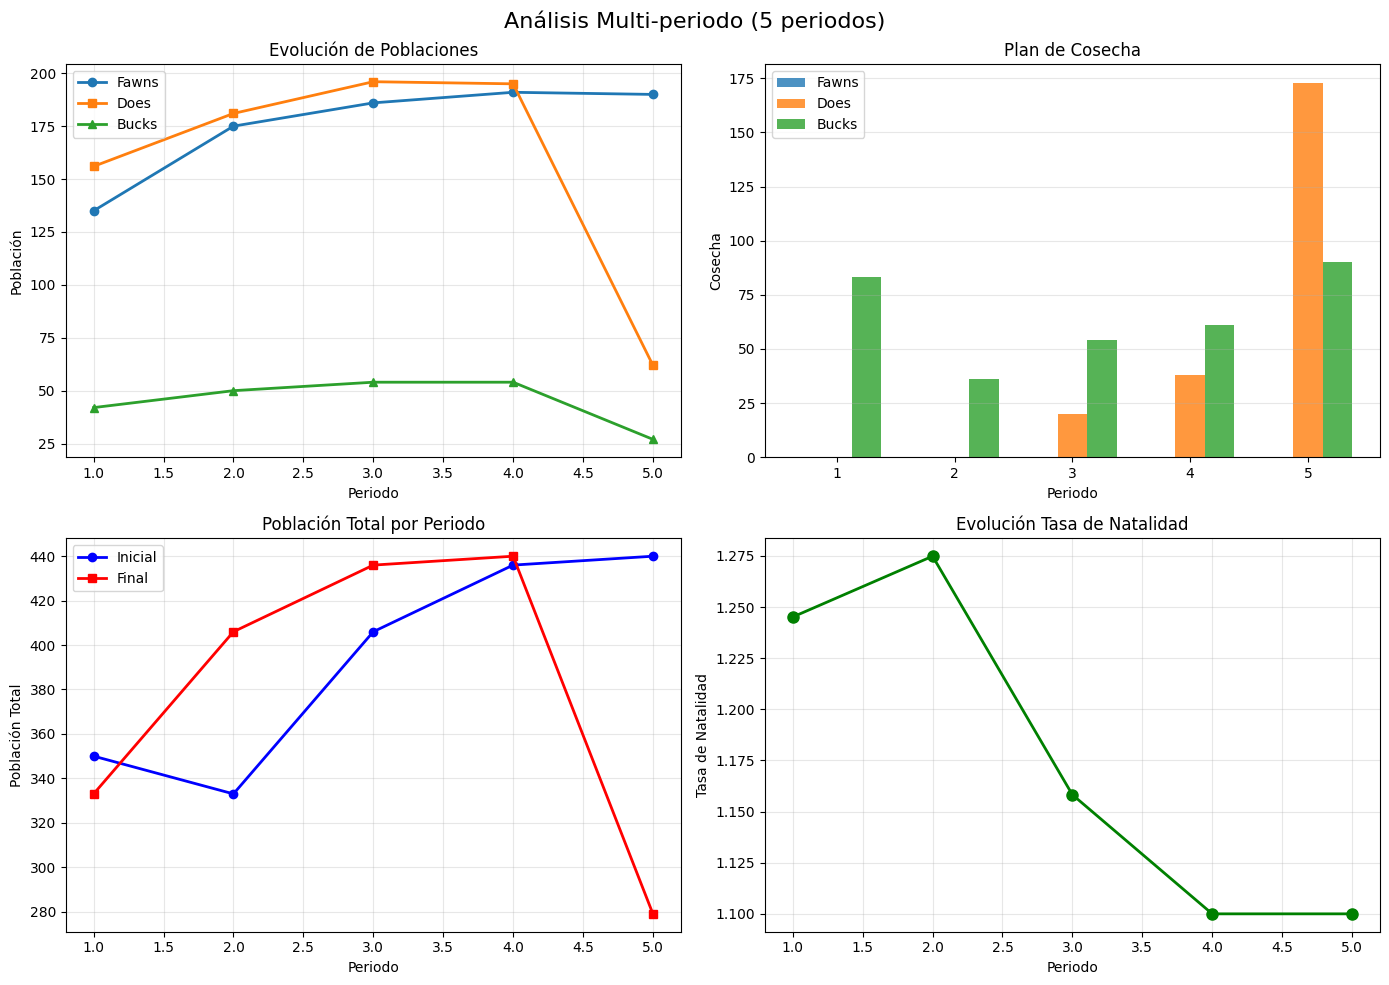

✅ Visualizaciones generadas

 FIN DEL ANÁLISIS


In [13]:
if 'df' in locals() and NUM_PERIODOS > 1:
    print("\n📊 Generando visualizaciones...")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Análisis Multi-periodo ({NUM_PERIODOS} periodos)', fontsize=16)

    # 1. Evolución poblaciones
    ax1 = axes[0, 0]
    ax1.plot(df['Periodo'], df['F_fin'], 'o-', label='Fawns', linewidth=2)
    ax1.plot(df['Periodo'], df['D_fin'], 's-', label='Does', linewidth=2)
    ax1.plot(df['Periodo'], df['B_fin'], '^-', label='Bucks', linewidth=2)
    ax1.set_xlabel('Periodo')
    ax1.set_ylabel('Población')
    ax1.set_title('Evolución de Poblaciones')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Cosechas por periodo
    ax2 = axes[0, 1]
    width = 0.25
    x = np.arange(len(df))
    ax2.bar(x - width, df['HF'], width, label='Fawns', alpha=0.8)
    ax2.bar(x, df['HD'], width, label='Does', alpha=0.8)
    ax2.bar(x + width, df['HB'], width, label='Bucks', alpha=0.8)
    ax2.set_xlabel('Periodo')
    ax2.set_ylabel('Cosecha')
    ax2.set_title('Plan de Cosecha')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['Periodo'])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Población total
    ax3 = axes[1, 0]
    ax3.plot(df['Periodo'], df['Pob_Total_Ini'], 'b-o', label='Inicial', linewidth=2)
    ax3.plot(df['Periodo'], df['Pob_Total_Fin'], 'r-s', label='Final', linewidth=2)
    ax3.set_xlabel('Periodo')
    ax3.set_ylabel('Población Total')
    ax3.set_title('Población Total por Periodo')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Tasa natalidad
    ax4 = axes[1, 1]
    ax4.plot(df['Periodo'], df['BR'], 'g-o', linewidth=2, markersize=8)
    ax4.set_xlabel('Periodo')
    ax4.set_ylabel('Tasa de Natalidad')
    ax4.set_title('Evolución Tasa de Natalidad')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✅ Visualizaciones generadas")

print("\n" + "="*70)
print(" FIN DEL ANÁLISIS")
print("="*70)

# Conclusiones

## Hallazgos Principales

### 1. Comparación de Modelos

El análisis comparativo entre el modelo de estado estacionario y el multi-periodo revela diferencias fundamentales:

- **Estado Estacionario**: Proporciona una solución teórica óptima (~62 bucks, ~37 does, ~0 fawns) que representa un equilibrio perpetuo ideal
- **Multi-periodo**: Ofrece una visión más realista de la evolución temporal, identificando tres fases: ajuste inicial (periodos 1-3), equilibrio sostenible (periodos 4-9), y el problema del horizonte finito (periodo final)

### 2. Equilibrio Natural Emergente

Un hallazgo significativo fue que el modelo multi-periodo converge naturalmente a un estado estacionario después de 3-4 periodos:
- Población estable: ~440 animales (190 fawns, 195 does, 54 bucks)
- Cosecha sostenible: ~102 animales/año
- Utilización completa del alimento disponible (100%)

### 3. Problema del Horizonte Finito

El modelo multi-periodo exhibe el clásico problema de optimización dinámica donde el último periodo presenta una cosecha excesiva (263 animales en el periodo 10), reduciendo la población al mínimo permitido. Esto resalta la importancia de:
- Incluir valores terminales en la función objetivo
- Considerar horizontes de planificación más largos
- Implementar restricciones de sostenibilidad explícitas

### 4. Ventajas de la Programación Estructurada con Blocks

El uso de blocks de Pyomo demostró ventajas significativas:
- **Modularidad**: Cada periodo es independiente pero conectado
- **Escalabilidad**: Fácil extensión a más periodos
- **Claridad**: Estructura jerárquica intuitiva
- **Mantenibilidad**: Cambios localizados por periodo

### 5. Implicaciones para la Gestión

Para la gestión práctica de poblaciones de ciervos, los resultados sugieren:
- La cosecha óptima sostenible es aproximadamente 23% de la población total anual
- Es crítico mantener proporciones mínimas por género para viabilidad genética
- El monitoreo continuo y ajuste adaptativo son esenciales
- Las restricciones de sostenibilidad deben ser explícitas, no implícitas

## Recomendaciones

1. **Para investigación futura**: Incorporar estocasticidad en tasas de natalidad y supervivencia
2. **Para implementación práctica**: Usar el modelo multi-periodo con horizonte rodante
3. **Para políticas públicas**: Establecer cuotas basadas en el equilibrio sostenible identificado (periodos 4-9)
4. **Para desarrollo de software**: Implementar interfaces gráficas para facilitar el uso por gestores no técnicos

## Limitaciones

- Asume poblaciones lo suficientemente grandes para variables continuas/enteras
- No considera variabilidad estacional o eventos estocásticos
- Simplifica la estructura de edad a solo tres categorías
- No incluye interacciones con otras especies o cambios en el hábitat

## Contribución

Este trabajo demuestra cómo la programación matemática moderna, específicamente el uso de programación estructurada con blocks, puede mejorar significativamente los modelos clásicos de gestión de recursos naturales, proporcionando herramientas más flexibles y realistas para la toma de decisiones en conservación.

# Referencias

Bailey, J. A. (1984). Optimal quotas for sustainable harvesting of deer populations. In S. L. Beasom & S. F. Roberson (Eds.), *Game harvest management* (pp. 103-106). Caesar Kleberg Wildlife Research Institute.

Bynum, M. L., Hackebeil, G. A., Hart, W. E., Laird, C. D., Nicholson, B. L., Siirola, J. D., Watson, J.-P., & Woodruff, D. L. (2021). *Pyomo - Optimization modeling in Python* (3rd ed., Vol. 67). Springer. https://doi.org/10.1007/978-3-030-68928-5

Hart, W. E., Watson, J.-P., & Woodruff, D. L. (2011). Pyomo: Modeling and solving mathematical programs in Python. *Mathematical Programming Computation*, 3(3), 219-260. https://doi.org/10.1007/s12532-011-0026-8

Nicholson, B., Siirola, J. D., Watson, J.-P., Zavala, V. M., & Biegler, L. T. (2018). pyomo.dae: A modeling and automatic discretization framework for optimization with differential and algebraic equations. *Mathematical Programming Computation*, 10(2), 187-223. https://doi.org/10.1007/s12532-017-0127-0

Universidad Autónoma de Ciudad Juárez. (2024). *Modelado estructurado con bloques* [Material del curso]. MIAAD.

Wächter, A., & Biegler, L. T. (2006). On the implementation of an interior-point filter line-search algorithm for large-scale nonlinear programming. *Mathematical Programming*, 106(1), 25-57. https://doi.org/10.1007/s10107-004-0559-y